# DATASET 관련 처리

## 라이브러리

In [1]:
import os
import glob
from pathlib import Path

import zipfile
import xlrd
import openpyxl
import json
import re
from tqdm import notebook

import tensorflow as tf
import pandas as pd
import numpy as np

import dlib
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2

## WORD_LIST

In [ ]:
!pip install xlrd

In [ ]:
!pip install openpyxl

In [13]:
KOREAN_WORD_XLS = 'datasets/한국어 학습용 어휘 목록.xls'

- xlrd 사용

In [14]:
# xls 파일 읽으려면 openpyxl 이 아니라 xlrd 라이브러리를 설치해야 함
wb = xlrd.open_workbook(KOREAN_WORD_XLS)
ws = wb.sheet_by_index(0)  # 엑셀 첫 번째 시트 불러오기
rows = ws.nrows  # 첫 번째 시트 행 수
cols = ws.ncols  # 첫 번째 시트 열 수

# 행별 저장 리스트
ws_data = []
for i in range(rows):
    ws_data.append(ws.row_values(i))

# 행별 저장 딕셔너리
ws_dict = {}
for row_num in range(rows):
    ws_dict[row_num] = {}
    for col in range(cols):
        ws_dict[row_num][col] = ws.cell_value(row_num, col)

- pandas 사용

In [15]:
pd_xls = pd.read_excel(KOREAN_WORD_XLS)
pd_xls

,순위,단어,품사,풀이,등급
0,1195.0,가게,명,NaN,A
1,898.0,가격03,명,價格,B
2,2986.0,가구03,명,家口,C
3,7434.0,가구04,명,家具,B
4,4964.0,가까워지다,동,NaN,B
...,...,...,...,...,...
5960,489.0,힘들다,형,NaN,A
5961,10357.0,힘들어하다,동,NaN,C
5962,3305.0,힘쓰다,동,NaN,C
5963,9013.0,힘없이,부,NaN,C


In [76]:
pd_xls[['단어']]

,단어
0,가게
1,가격03
2,가구03
3,가구04
4,가까워지다
...,...
5960,힘들다
5961,힘들어하다
5962,힘쓰다
5963,힘없이


In [78]:
pd_xls.iloc[:, [1,2,4]]

,단어,품사,등급
0,가게,명,A
1,가격03,명,B
2,가구03,명,C
3,가구04,명,B
4,가까워지다,동,B
...,...,...,...
5960,힘들다,형,A
5961,힘들어하다,동,C
5962,힘쓰다,동,C
5963,힘없이,부,C


## AI Hub Dataset

### 파일명: `(word_id)_(actor_id)_(camera_id)_(frame_idx).ext`
- word_id = 동작별 고유 ID 값
- actor_id = 모델 고유 ID 값
- camera_id = 카메라 ID(C:center, D:down, L:left, R:right, U:up)
- frame_idx = 추출 이미지 프레임 번호

In [16]:
# AI HUB Dataset 파일명 형식
file_name_format = {
    'word_id': 0,
    'actor_id': 0,
    'camera_id': 0,
    'frame_idx': 0,
}

### 데이터 개수 & 구성

- word_id: 단어 발화 종류 한국어 학습용 어휘 1000개
    - 단어별 품사 개수

|감탄사|고유명사|관형사|대명사|동사|보조용언|
|:---:|:---:|:---:|:---:|:---:|:---:|
|12|21|25|25|151|2|
|부사|수사|의존 명사|형용사|명사|생활용어|
|61|35|28|69|514|57|

- actor_id: 195명
    - 남자 93명
    - 여자 102명

|10대|20대|30대|40대|50대|60대 이상|
|:---:|:---:|:---:|:---:|:---:|:---:|
|32|36|31|31|36|29|

- camera_id: C, D, L, R, U

|C|D|L|R|U|
|:---:|:---:|:---:|:---:|:---:|
|Center|Down|Left|Right|Up|

- frame_idx: 단어당 1초 내외 30fps

In [17]:
# lip_dataword_list.txt
AI_HUB_LIP_DATAWORD_TXT = 'datasets/mouth/lip_dataword_list.txt'

lip_dataword_idx = []
if os.path.exists(AI_HUB_LIP_DATAWORD_TXT):
    with open(AI_HUB_LIP_DATAWORD_TXT) as txt_file:
        lip_dataword_idx = list(map(lambda x: x.strip(), txt_file.readlines()))

In [18]:
# AI HUB 데이터셋 경로
DATASET_AI_HUB_ROOT = 'datasets/mouth/Sample'

# directory 없으면 새로 생성
try:
    if not os.path.exists(DATASET_AI_HUB_ROOT):
        os.makedirs(DATASET_AI_HUB_ROOT)
except OSError as e:
    print(e)

# 데이터셋 폴더명 리스트
dataset_ai_hub_dir_list = os.listdir(DATASET_AI_HUB_ROOT)

In [ ]:
for datasets_dir in dataset_ai_hub_dir_list:
    datasets_dir_dir = os.listdir(os.path.join(DATASET_AI_HUB_ROOT, datasets_dir))
    for datasets_split in datasets_dir_dir:
        datasets_file_name = datasets_split.split('_')
        print(datasets_file_name)

- JSON 파일
    - `(word_id)_(actor_id)_(camera_id)_(frame_idx).json`
        - word_id = 동작별 고유 ID 값
        - actor_id = 모델 고유 ID 값
        - camera_id = 카메라 ID(C:center, D:down, L:left, R:right, U:up)
        - frame_idx = 추출 이미지 프레임 번호
    - 데이터 포맷: json 파일 포맷
    - 데이터 구성: 24개 입술 특징 위치/키포인트 (x,y)<br>![](datasets/AI_HUB_%EC%9E%85%EC%88%A0_%ED%82%A4%ED%8F%AC%EC%9D%B8%ED%8A%B8.PNG)
        - 입술 inner line: 총 12개 특징점, index 0 ~ 11
        - 입술 outer line: 총 12개 특징점, index 12 ~ 23

|index|입술 정보|index|입술 정보|
|:---:|:---:|:---:|:---:|
|0|outer_0_left|12|inner_0_left|
|1|outer_1|13|inner_1|
|2|outer_2|14|inner_2|
|3|outer_3_top|15|inner_3_top|
|4|outer_4|16|inner_4|
|5|outer_5|17|inner_5|
|6|outer_6_right|18|inner_6_right|
|7|outer_7|19|inner_7|
|8|outer_8|20|inner_8|
|9|outer_9_bottom|21|inner_9_bottom|
|10|outer_10|22|inner_10|
|11|outer_11|23|inner_11|

In [19]:
json_path = 'datasets/mouth/Sample/0001_M003/0001_M003_C/0001_M003_C_0000000.json'
with open(json_path) as label:
    json_data = json.load(label)

json_data.keys()

dict_keys(['categories', 'licenses', 'info', 'annotations', 'videos', 'images', 'meshs', 'actor'])

In [20]:
json_data['categories']

[{'type': 'Lip',
  'type_id': 0,
  'keypoints': ['outer_0_left',
   'outer_1',
   'outer_2',
   'outer_3_top',
   'outer_4',
   'outer_5',
   'outer_6_right',
   'outer_7',
   'outer_8',
   'outer_9_bottom',
   'outer_10',
   'outer_11',
   'inner_0_left',
   'inner_1',
   'inner_2',
   'inner_3_top',
   'inner_4',
   'inner_5',
   'inner_6_right',
   'inner_7',
   'inner_8',
   'inner_9_bottom',
   'inner_10',
   'inner_11'],
  'segments': [[0, 11], [12, 23]]}]

In [21]:
json_data['annotations']

[{'id': 230615,
  'image_name': '0001_M003_C_0000000.jpg',
  'image_id': 246541,
  'video_id': 42261,
  'bbox': [725, 894, 113, 63],
  'segmentation': [[725,
    918,
    748,
    903,
    766,
    894,
    783,
    899,
    801,
    895,
    819,
    902,
    838,
    910,
    829,
    935,
    811,
    952,
    785,
    957,
    757,
    953,
    737,
    937],
   [727,
    919,
    748,
    908,
    763,
    906,
    783,
    908,
    801,
    907,
    819,
    906,
    835,
    912,
    824,
    926,
    807,
    934,
    784,
    939,
    763,
    939,
    743,
    932]],
  'area': [4983, 2568],
  'actor_id': 'M003',
  'word': '그',
  'word_id': 1,
  'num_keypoints': 24,
  '2D keypoints': [725,
   918,
   2,
   748,
   903,
   2,
   766,
   894,
   2,
   783,
   899,
   2,
   801,
   895,
   2,
   819,
   902,
   2,
   838,
   910,
   2,
   829,
   935,
   2,
   811,
   952,
   2,
   785,
   957,
   2,
   757,
   953,
   2,
   737,
   937,
   2,
   727,
   919,
   2,
   748,
   908

In [60]:
json_data['videos']

[{'id': 42261,
  'frame_rate': 30.0,
  'width': 1600,
  'height': 1200,
  'camera_id': 0,
  'parameters': {'intrinsic': [2802.3299,
    2794.0078,
    797.66935,
    618.9035,
    0.0,
    0.0,
    0.0,
    0.0],
   'extrinsic': [0.99999859,
    0.00011165856,
    -0.0016778532,
    117.531,
    -0.0001200091,
    0.9999876,
    -0.0049776439,
    -0.28542619,
    0.0016772766,
    0.0049778382,
    0.9999862,
    -1.0499686]},
  'file_name': '0001_M003_C.mp4',
  'date_captured': '2020-10-14 00:00:00'}]

In [59]:
json_data['images']

[{'id': 246541,
  'file_name': '0001_M003_C_0000000.jpg',
  'width': 1600,
  'height': 1200,
  'frame_index': 0}]

In [58]:
json_data['actor']

[{'id': 'M003', 'sex': 'female', 'age': 60}]

- JPG 파일
    - `(word_id)_(actor_id)_(camera_id)_(frame_idx).jpg`
        - word_id = 동작별 고유 ID 값
        - actor_id = 모델 고유 ID 값
        - camera_id = 카메라 ID(C:center, D:down, L:left, R:right, U:up)
        - frame_idx = 추출 이미지 프레임 번호
    - 데이터 포맷: jpg 파일 포맷
    - 데이터 구성: Full-HD 영상, 카메라 파라미터    

In [41]:
image_name = json_data['annotations'][0]['image_name']
jpg_path = f"datasets/mouth/Sample/0001_M003/0001_M003_C/{image_name}"
jpg_path

'datasets/mouth/Sample/0001_M003/0001_M003_C/0001_M003_C_0000000.jpg'

In [61]:
word = json_data['annotations'][0]['word']
word

'그'

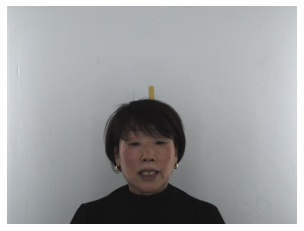

In [46]:
image = img.imread(jpg_path)
plt.imshow(image)
plt.axis("off")
plt.show()

- bbox 시각화

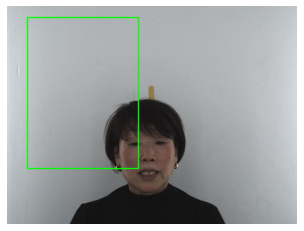

In [57]:
image = cv2.imread(jpg_path)
orignal = image.copy()

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
left_x, left_y, right_x, right_y = json_data['annotations'][0]['bbox']  # [x,y,x,y]
cv2.rectangle(image, (left_x, left_y), (right_x, right_y), (0,255,0), 5)
plt.imshow(image)
plt.axis("off")
plt.show()

- 입술 keypoint 시각화

In [65]:
num_keypoints = json_data['annotations'][0]['num_keypoints']
keypoints = json_data['categories'][0]['keypoints']

keypoints_dict = {num: keypoint for num, keypoint in zip(range(num_keypoints), keypoints)}
keypoints_dict

{0: 'outer_0_left',
 1: 'outer_1',
 2: 'outer_2',
 3: 'outer_3_top',
 4: 'outer_4',
 5: 'outer_5',
 6: 'outer_6_right',
 7: 'outer_7',
 8: 'outer_8',
 9: 'outer_9_bottom',
 10: 'outer_10',
 11: 'outer_11',
 12: 'inner_0_left',
 13: 'inner_1',
 14: 'inner_2',
 15: 'inner_3_top',
 16: 'inner_4',
 17: 'inner_5',
 18: 'inner_6_right',
 19: 'inner_7',
 20: 'inner_8',
 21: 'inner_9_bottom',
 22: 'inner_10',
 23: 'inner_11'}

In [83]:
keypoints_pos = json_data['annotations'][0]['2D keypoints']
pos_dict = {
    'x': 0,
    'y': 0,
    'z': 0
}
keypoints_pos_dict = {}
poses = []
for i, pos in enumerate(keypoints_pos):
    if pos == 2:
        keypoints_pos_dict[i//3] = poses
        poses = []
    else:
        poses.append(pos)

keypoints_pos_dict

{0: [725, 918],
 1: [748, 903],
 2: [766, 894],
 3: [783, 899],
 4: [801, 895],
 5: [819, 902],
 6: [838, 910],
 7: [829, 935],
 8: [811, 952],
 9: [785, 957],
 10: [757, 953],
 11: [737, 937],
 12: [727, 919],
 13: [748, 908],
 14: [763, 906],
 15: [783, 908],
 16: [801, 907],
 17: [819, 906],
 18: [835, 912],
 19: [824, 926],
 20: [807, 934],
 21: [784, 939],
 22: [763, 939],
 23: [743, 932]}

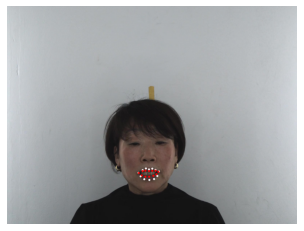

In [108]:
image = cv2.imread(jpg_path)
orignal = image.copy()

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for i, (x,y) in keypoints_pos_dict.items():
    if i < 12:  # inner (0 ~ 11)
        color = (255,255,255)
    else:  # outer (12 ~ 23)
        color = (255,0,0)
    cv2.circle(image, (x,y), 3, color, 3)

plt.imshow(image)
plt.axis("off")
plt.show()

- 입술 bounding box 그리기

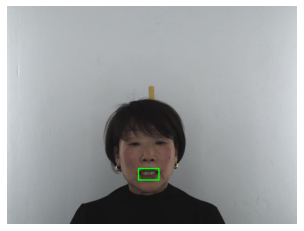

In [109]:
image = cv2.imread(jpg_path)
orignal = image.copy()

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

x_list = list(zip(*keypoints_pos_dict.values()))[0]
y_list = list(zip(*keypoints_pos_dict.values()))[1]

left_x = min(x_list)
left_y = min(y_list)
right_x = max(x_list)
right_y = max(y_list)
cv2.rectangle(image, (left_x, left_y), (right_x, right_y), (0,255,0), 5)

plt.imshow(image)
plt.axis("off")
plt.show()

## Youtube Dataset

1. Youtube 영상 저장
2. Youtube 영상 처리
    - 프레임 캡처
    - tensor 변환

- [Youtube 영상 저장 1](https://hleecaster.com/python-pytube/)

In [ ]:
!pip install pytube

In [ ]:
from pytube import YouTube

DOWNLOAD_FOLDER = "C:\\Users\\User\\Desktop"
url = "https://www.youtube.com/watch?v=d6LGnVCL1_A"

yt = YouTube(url)

# 저장
stream = yt.streams.get_highest_resolution()
stream.download(DOWNLOAD_FOLDER)

# 정보 출력
print("제목 : ", yt.title)
print("길이 : ", yt.length)
print("게시자 : ", yt.author)
print("게시날짜 : ", yt.publish_date)
print("조회수 : ", yt.views)
print("키워드 : ", yt.keywords)
print("설명 : ", yt.description)
print("썸네일 : ", yt.thumbnail_url)

In [ ]:
from pytube import Playlist

DOWNLOAD_FOLDER = "C:\\Users\\User\\Desktop"
p = Playlist('https://www.youtube.com/watch?v=ea7hkgs9DJo&list=PLsBObkGU9zQMirwoCV2lgHOl5fqXIlcxI')

# 플레이리스트 영상 모두 저장
for video in p.videos:
    video.streams.first().download(DOWNLOAD_FOLDER)

- [Youtube 영상 저장2](https://eehoeskrap.tistory.com/519)

In [ ]:
import os
import pytube  # pip install pytube
from pytube.cli import on_progress

url = "유튜브 링크"
yt = pytube.YouTube(url, on_progress_callback=on_progress)
print(yt.streams)
save_dir = "./" # 저장경로
yt.streams.filter(progressive=True, file_extension="mp4")\
    .order_by("resolution")\
    .desc()\
    .first()\
    .download(save_dir)

- [Youtube 영상 처리](https://velog.io/@bangsy/Python-OpenCV-4)

In [ ]:
!pip install pafy
!pip install youtube-dl

In [ ]:
import pafy
import cv2
 
url = "https://www.youtube.com/watch?v=gdZLi9oWNZg"
video = pafy.new(url)

print("video title : {}".format(video.title))  # 제목
print("video rating : {}".format(video.rating))  # 평점
print("video viewcount : {}".format(video.viewcount))  # 조회수
print("video author : {}".format(video.author))  # 저작권자
print("video length : {}".format(video.length))  # 길이
print("video duration : {}".format(video.duration))  # 길이
print("video likes : {}".format(video.likes)) # 좋아요
print("video dislikes : {}".format(video.dislikes)) #싫어요

best = video.getbest(preftype="mp4")
print("best resolution : {}".format(best.resolution))

cap = cv2.VideoCapture(best.url) 
 
# 동영상 크기(frame정보)를 읽어옴
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
# 동영상 프레임을 캡쳐
frameRate = int(cap.get(cv2.CAP_PROP_FPS))
 
frame_size = (frameWidth, frameHeight)
print('frame_size={}'.format(frame_size))
print('fps={}'.format(frameRate))
 
# cv2.VideoWriter_fourcc(*'코덱')
# codec 및 녹화 관련 설정
# 인코딩 방식을 설정
fourcc = cv2.VideoWriter_fourcc(*'XVID')
#fourcc = cv2.VideoWriter_fourcc(*'DIVX')
#fourcc = cv2.VideoWriter_fourcc(*'MPEG')
#fourcc = cv2.VideoWriter_fourcc(*'X264')
 
out1Path = 'data/recode1.mp4'
out2Path = 'data/recode2.mp4'
 
# 영상 저장하기
# out1Path : 저장할 파일명
# fourcc : frame 압축 관련 설정(인코딩, 코덱 등)
# frameRate : 초당 저장할 frame
# frame_size : frame 사이즈(가로, 세로)
# isColor : 컬러 저장 여부
out1 = cv2.VideoWriter(out1Path, fourcc, frameRate, frame_size)
out2 = cv2.VideoWriter(out2Path, fourcc, frameRate, frame_size)

while True:
    # 한 장의 이미지를 가져오기
    # 이미지 -> frame
    # 정상적으로 읽어왔는지 -> retval
    retval, frame = cap.read()
    if not(retval):
        break  # 프레임정보를 정상적으로 읽지 못하면 while문을 빠져나가기
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)	# 회색으로 컬러 변환
    edges = cv2.Canny(gray, 100, 200)	# Canny함수로 엣지 따기
    
    # 동영상 파일에 쓰기
    out1.write(frame)
    out2.write(edges)
    
    # 모니터에 출력
    cv2.imshow('frame', frame)
    cv2.imshow('edges', edges)
    
    key = cv2.waitKey(frameRate)  # frameRate msec동안 한 프레임을 보여준다
    
    # 키 입력을 받으면 키값을 key로 저장 -> esc == 27
    if key == 27:
        break
        
if cap.isOpened():
    cap.release()
    out1.release()
    out2.release()
    
cv2.destroyAllWindows()

- [Youtube to frames](https://github.com/arundasan91/Machine-Learning/blob/master/OpenCV/youtube-to-frames.py)

In [ ]:
def video_to_frames_url_auto(url=None, folder='/home/cc/projects/'):
    """Function to extract frames from input video url or file and save them as separate frames 
    in an output directory. Output directory will be named starting from video_1. If a new file is downloaded,
    a video_2 folder will be created and so on.
    Dependencies: 
        OpenCV
        youtube-dl (sudo pip install --upgrade youtube_dl)
    
    Args:
        url: Youtube video URL.
        folder: Directory to download and save each frames.
        
    Returns:
        None
        
    Work to be done:
    1. Handle exceptions
    """
    import os
    import re
    import cv2
    import time
    
    # Log start time
    time_start = time.time()
    
    # To make a directory for saving video automatically considering all the existing foldernames
    reg = re.compile(r'^video_')
    lst = sorted(os.listdir(folder))
    newlist = filter(reg.match, lst)
    numbers = [reg.sub('', x).strip() for x in newlist]
    results = map(int, numbers)
    results = sorted(results)
    newfile = results[-1] + 1
    # Make a directory for the video
    # If no video's exist as of now, create a folder.
    if(results == None):
        os.mkdir("video_1")
    # Create a folder according to the files that are already present.   
    os.mkdir("video_" + str(newfile))
    
    file_loc = folder + "video_" + str(newfile) + "/video_" + str(newfile) + ".mp4"
    # Download from local video file
    if (url):
        print("Downloading Youtube Video")
        os.system("youtube-dl -o " + file_loc + " -f mp4 " + url)
        cap = cv2.VideoCapture(file_loc)
    else:
        print("This is where I should raise an error. --EXCEPTION HANDLING--")

    video_length = int(cap.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    print ("Converting video..\n")
    while cap.isOpened():
        ret,frame = cap.read()

        cv2.imwrite(folder + "video_" + str(newfile) + "/%d.jpg" % (count+1), frame)
        count = count + 1
        if (count > (video_length-1)):
            time_end = time.time()
            cap.release()
            print "Done extracting frames.\n%d frames extracted" %count
            print "It took %d seconds for conversion." %(time_end-time_start)
            break

- [Youtube capture frames](https://github.com/qaixerabbas/youtube-frame-capture/blob/master/youtube_videos_capture_frames.py)

In [ ]:
!pip install vidgear

In [ ]:
### Capturing images from YouTube videos without downloading Video using Python's VidGear Module
## pip install vidgear
import cv2
import os
from vidgear.gears import CamGear
### Replace this youtube video link with your one
stream = CamGear(source='https://www.youtube.com/watch?v=lQc432kUOpM', y_tube =True,  time_delay=1, logging=True).start()

#this should be the path where u want ur images
path  = 'C:\\Users\\user\\Desktop\\Capture Frames from Online YouTube Video\\cars\\'

currentframe = 0
while True:

    frame = stream.read() ### using functions from vidGear module
    if frame is None:
        break

    cv2.imshow("Output Frame", frame) # optional if u want to show the frames

    name = path + './frames' + str(currentframe) + '.jpg'
    print ('Creating...' + name) 

    cv2.imwrite(name, frame)
    currentframe += 5 ##chnage 5 with the number of frames. Here 5 means capture frame after every 5 frames
    ###usually videos are 30fps so if here 30 is provided a frame will be captures after every second.

    key = cv2.waitKey(1) & 0xFF

    if key == ord("q"):
        break

cv2.destroyAllWindows()
stream.stop()
stream.stop()

## Video Preprocessing

1. 영상 프레임별 캡처
2. 영상 텐서 변환

- 영상 프레임별 캡처

In [ ]:
def vid2Frame(vid_file, save_dir):
    v_cap = cv2.VideoCapture(os.path.join(os.path.curdir, vid_file))

    cnt = 0
    while v_cap.isOpened():
        success, image = v_cap.read()  # BGR

        if success and int(v_cap.get(1)) % 10 == 0:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # GRAY
            image = cv2.resize(image, dsize=(1600, 1200), interpolation=cv2.INTER_LINEAR)  # (1920, 1080)
            cv2.imwrite(os.path.join(os.path.curdir, 'capture', '%d.png' % v_cap.get(1)), image)
            print("Frame Captured: %d" % v_cap.get(1))
            cnt += 1

    v_cap.release()


- 영상 텐서 변환

In [ ]:
def vid2tensor():
    pass

In [ ]:
def img2np():
    pass

## Augmentation

- imgaug 사용 [참고](https://junyoung-jamong.github.io/machine/learning/2019/01/23/%EB%B0%94%EC%9A%B4%EB%94%A9%EB%B0%95%EC%8A%A4%EB%A5%BC-%ED%8F%AC%ED%95%A8%ED%95%9C-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%A6%9D%ED%8F%AD%EC%8B%9C%ED%82%A4%EA%B8%B0-with-imgaug.html)
    - Annotation을 포함한 이미지 증폭을 수행 => 모든 객체의 Bounding-box를 함께 회전
    - ![](https://junyoung-jamong.github.io/assets/image/how_to_use_imgaug/img1.png)

In [ ]:
# 사용 방법 더 찾아볼 것

- 일반적인 augmentation

In [ ]:
def data_augmentation(image, mode):
    if mode == 0:
        # original
        return image
    elif mode == 1:
        # flip up and down
        return np.flipud(image)
    elif mode == 2:
        # rotate counterwise 90 degree
        return np.rot90(image)
    elif mode == 3:
        # rotate 90 degree and flip up and down
        image = np.rot90(image)
        return np.flipud(image)
    elif mode == 4:
        # rotate 180 degree
        return np.rot90(image, k=2)
    elif mode == 5:
        # rotate 180 degree and flip
        image = np.rot90(image, k=2)
        return np.flipud(image)
    elif mode == 6:
        # rotate 270 degree
        return np.rot90(image, k=3)
    elif mode == 7:
        # rotate 270 degree and flip
        image = np.rot90(image, k=3)
        return np.flipud(image)

def load_images(file):
    im = Image.open(file)
    return np.array(im, dtype="float32") / 255.0

def save_images(filepath, result_1, result_2 = None):
    result_1 = np.squeeze(result_1)
    result_2 = np.squeeze(result_2)

    if not result_2.any():
        cat_image = result_1
    else:
        cat_image = np.concatenate([result_1, result_2], axis = 1)

    im = Image.fromarray(np.clip(cat_image * 255.0, 0, 255.0).astype('uint8'))
    im.save(filepath, 'png')

## Crop

### AI HUB json 활용

In [ ]:
# 위에서 json 파싱해서 bbox 위치 구해서 crop

### dlib 활용

#### 이미지

- 얼굴 찾기

In [ ]:
# 이미지 읽기
my_image_path = 'images/image.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_bgr)
plt.show()

In [ ]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

In [ ]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [ ]:
face_landmark_model_path = "models/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(face_landmark_model_path)

- 입술 찾기
    - 번호 확인<br>![](https://camo.githubusercontent.com/8db3b9fba6dcb44f527a98e3a2f1ebeffcfbb3ad421c05e476d1c2c88f1fe254/68747470733a2f2f6433733074736b6166616c6c6c392e636c6f756466726f6e742e6e65742f6d656469612f6f726967696e616c5f696d616765732f452d382d382e706e67)
    - 입술 번호: 48 ~ 67
    - [코드 참고](https://github.com/dnwjddl/LipReading_Korean/blob/master/data/Preprocessing_dataset.ipynb)

In [ ]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((20, 2), dtype=dtype)
    # for only lip landmarks (48 ~ 67)
    n = 0
    for i in range(48, shape.num_parts):
        coords[n] = (shape.part(i).x, shape.part(i).y)
        n += 1

    # return the list of (x, y)-coordinates
    return coords

In [ ]:
faces = f'datasets/mouth/Crop'
for jpg in os.listdir(faces):
    if jpg[3:6] not in ['_0.', '_1.', '_2.', '_3.', '_4.']:
        pass
    else:
        dir = f'{faces}/{i}'
        src = cv2.imread(dir, cv2.IMREAD_COLOR)
        img_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
        face_detector = detector_hog(img_gray, 1)
        for face in face_detector:
            landmarks = predictor(src, face)
            landmarks = shape_to_np(landmarks)
            print("gotfaces!")

- 입술 crop

In [ ]:
# crop 후 저장

#### 영상

- 얼굴/입술 찾기

In [ ]:
!pip install sk-video

In [ ]:
import dlib
import skvideo.io
import cv2

## face detector와 landmark predictor 정의
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

## 비디오 읽어오기
cap = skvideo.io.vreader('test.mp4')

## 각 frame마다 얼굴 찾고, landmark 찍기
for frame in cap:    
    img = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    r = 200. / img.shape[1]
    dim = (200, int(img.shape[0] * r))    
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    rects = detector(resized, 1)
    for i, rect in enumerate(rects):
        l = rect.left()
        t = rect.top()
        b = rect.bottom()
        r = rect.right()
        shape = predictor(resized, rect)
        # for j in range(68):  # Face Detection
        for j in range(48, 68):  # Mouth Detection
            x, y = shape.part(j).x, shape.part(j).y
            cv2.circle(resized, (x, y), 1, (0, 0, 255), -1)
        cv2.rectangle(resized, (l, t), (r, b), (0, 255, 0), 2)
        cv2.imshow('frame', resized)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
cv2.destroyAllWindows()

- 입술 crop

In [ ]:
# crop 후 저장